<a href="https://colab.research.google.com/github/anushChrist/DL_Lab/blob/main/2348504_Lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
from keras.layers import BatchNormalization, RandomFlip,RandomRotation,RandomZoom, Input
from tensorflow.keras.applications import VGG16
import random
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from tensorflow.keras.models import load_model

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Loading Data

In [ ]:
# zip_file_path = 'archive.zip'
# extract_to_directory = './archive'
# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to_directory)

In [ ]:
train_path = 'archive/melanoma_cancer_dataset/train'
test_path = 'archive/melanoma_cancer_dataset/test'

class_mapping = {'benign': 0, 'malignant': 1}

def load(path):
    labels = []
    images = []
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)
        image_files = os.listdir(folder_path)
        print(f'{len(image_files)} in folder {folder_name}')
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            image = cv2.imread(image_path)
            resized_image = cv2.resize(image, (200, 200))
            images.append(resized_image.astype(np.float16) / 255)
            labels.append(class_mapping[folder_name])
    return np.array(images), np.array(labels)


In [ ]:
X_train, Y_train = load(train_path)
X_test, Y_test = load(test_path)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

5000 in folder benign
4605 in folder malignant
500 in folder benign
500 in folder malignant


In [ ]:
np.save('train_images.npy', X_train)
np.save('train_labels.npy', Y_train)
np.save('test_images.npy', X_test)
np.save('test_labels.npy', Y_test)

In [ ]:
X_train = np.load('train_images.npy')
Y_train = np.load('train_labels.npy')

X_test = np.load('test_images.npy')
Y_test = np.load('test_labels.npy')

## Displaying Sample Images

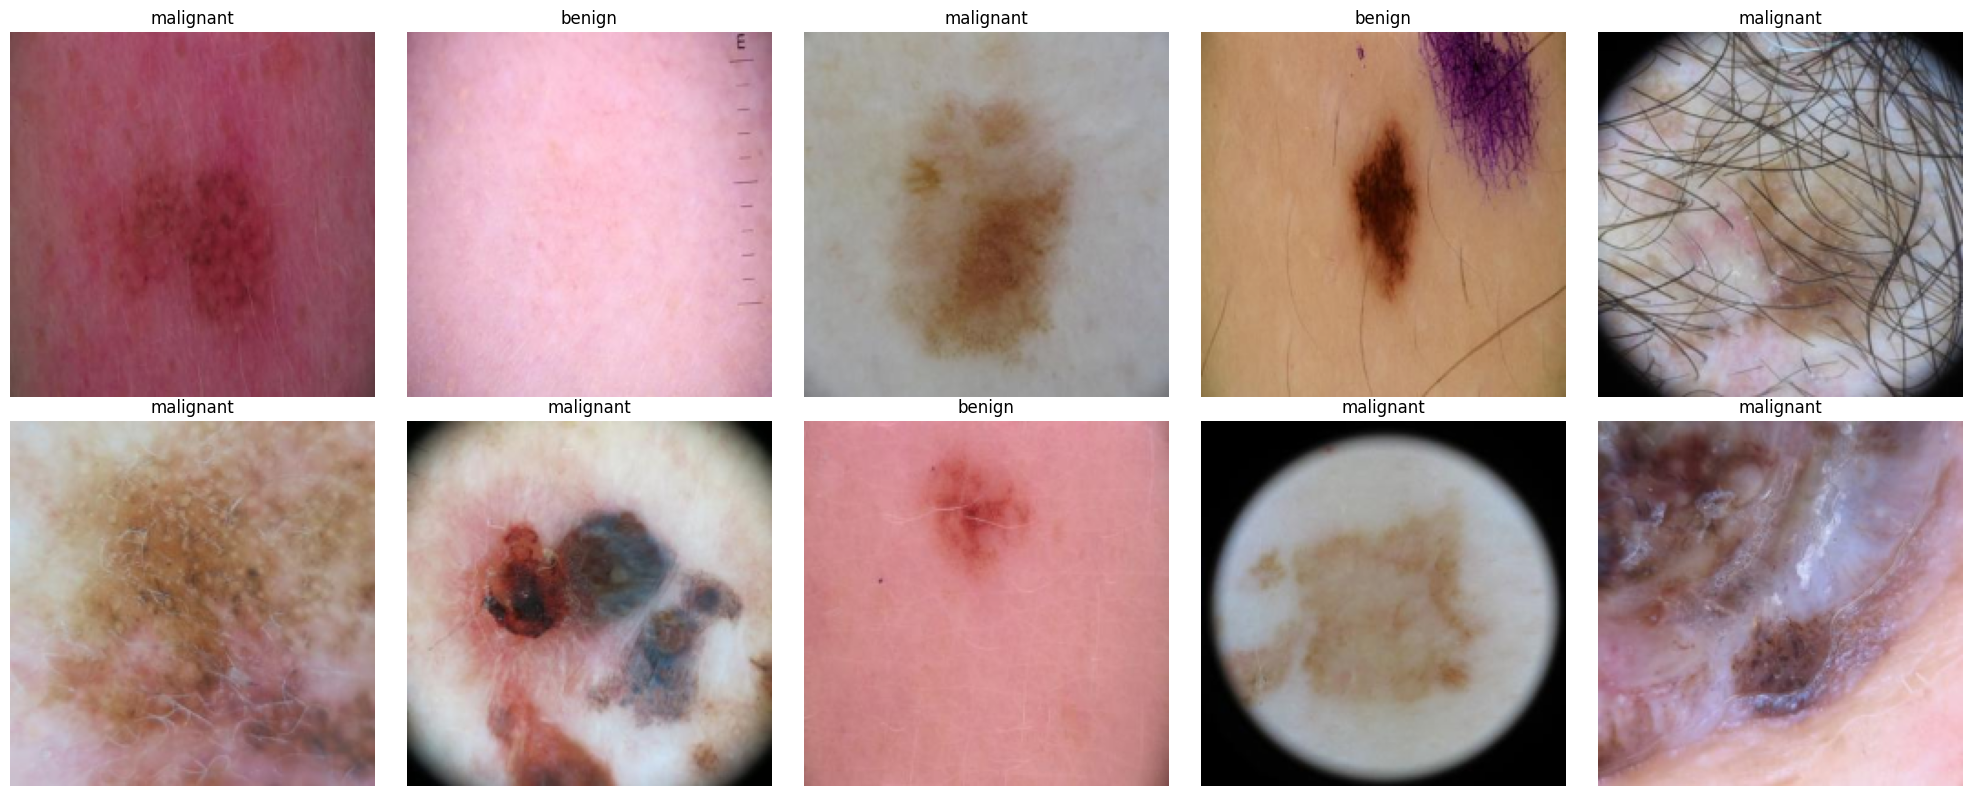

In [ ]:
indices = np.random.choice(range(len(X_train)), 10, replace=False)
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, idx in enumerate(indices):
    row, col = divmod(i, 5)
    ax = axes[row, col]
    img_display = cv2.cvtColor(X_train[idx].astype('float32'), cv2.COLOR_BGR2RGB)
    ax.imshow(img_display)
    label = reverse_class_mapping[np.argmax(Y_train[idx])]
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()


# Custom Model

### Custom CNN Model

In [ ]:
modelCustom = Sequential([
    Input(shape=(200,200,3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1)])
# convolutional layer
modelCustom.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
modelCustom.add(MaxPool2D(pool_size=(2,2)))
modelCustom.add(BatchNormalization())
# convolutional layer
modelCustom.add(Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
modelCustom.add(MaxPool2D(pool_size=(2,2)))
modelCustom.add(BatchNormalization())

modelCustom.add(Conv2D(128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
modelCustom.add(MaxPool2D(pool_size=(2,2)))
modelCustom.add(BatchNormalization())

modelCustom.add(Conv2D(256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
modelCustom.add(MaxPool2D(pool_size=(2,2)))
modelCustom.add(BatchNormalization())
# flatten output of conv
modelCustom.add(Flatten())

# hidden layer
modelCustom.add(Dense(512, activation='relu'))
modelCustom.add(Dropout(0.5))
modelCustom.add(Dense(512, activation='relu'))
modelCustom.add(Dropout(0.5))

# output layer
modelCustom.add(Dense(2, activation='softmax'))

In [ ]:
modelCustom.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
modelCustom.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 200, 200, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,528,898 (74.50 MB)

 Trainable params: 19,527,938 (74.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
modelCustom.fit(X_train, Y_train, batch_size=16, epochs=5,validation_data=(X_test, Y_test))

Epoch 1/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 477s 784ms/step - accuracy: 0.7430 - loss: 7.7336 - val_accuracy: 0.6790 - val_loss: 0.7839
Epoch 2/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 469s 781ms/step - accuracy: 0.7845 - loss: 0.8444 - val_accuracy: 0.8730 - val_loss: 0.3142
Epoch 3/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 482s 802ms/step - accuracy: 0.8143 - loss: 0.4630 - val_accuracy: 0.8830 - val_loss: 0.2913
Epoch 4/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 509s 848ms/step - accuracy: 0.8312 - loss: 0.4360 - val_accuracy: 0.8820 - val_loss: 0.2722
Epoch 5/5
601/601 ━━━━━━━━━━━━━━━━━━━━ 505s 840ms/step - accuracy: 0.8344 - loss: 0.3904 - val_accuracy: 0.8850 - val_loss: 0.2919


### Saving Model

In [ ]:
modelCustom.save('./modelCustom.keras')

### Loading Model

In [ ]:
modelCustom = load_model('./modelCustom.keras')

In [ ]:
historyCustom = modelCustom.history

AttributeError: 'Sequential' object has no attribute 'history'

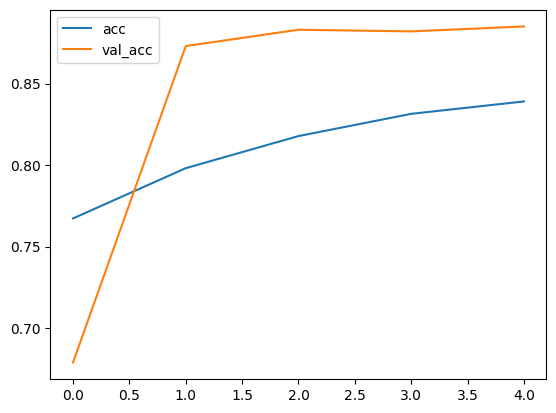

In [ ]:
plt.plot(historyCustom.history['accuracy'], label='acc')
plt.plot(historyCustom.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

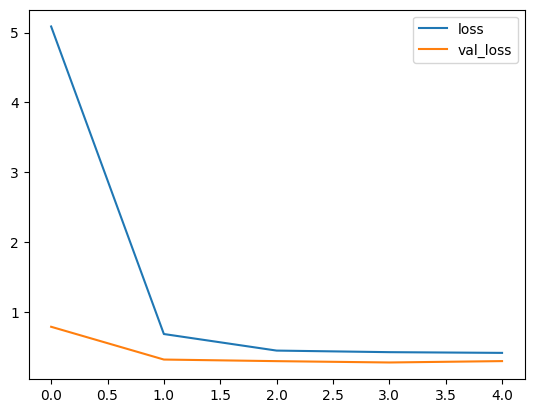

In [ ]:
plt.plot(historyCustom.history['loss'], label='loss')
plt.plot(historyCustom.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# VGG16 model

In [ ]:
model_vgg16 = VGG16(input_shape=(200,200,3), include_top=False, weights='imagenet')

### Setting Model Layer Training to False

In [ ]:
for layer in model_vgg16.layers:
   layer.trainable=False
model_vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
modelVGG = Sequential()
modelVGG.add(model_vgg16)
modelVGG.add(Flatten())
modelVGG.add(Dense(256, activation='relu'))
modelVGG.add(Dropout(0.5))
modelVGG.add(Dense(2, activation='softmax'))
modelVGG.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
modelVGG.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
modelVGG.fit(X_train, Y_train, batch_size=128, epochs=5,validation_data=(X_test, Y_test))

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 576s 7s/step - accuracy: 0.7458 - loss: 0.6788 - val_accuracy: 0.8880 - val_loss: 0.2739
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 518s 7s/step - accuracy: 0.8893 - loss: 0.2732 - val_accuracy: 0.8630 - val_loss: 0.3103
Epoch 3/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 512s 7s/step - accuracy: 0.8898 - loss: 0.2611 - val_accuracy: 0.8950 - val_loss: 0.2440
Epoch 4/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 1453s 19s/step - accuracy: 0.8918 - loss: 0.2574 - val_accuracy: 0.9010 - val_loss: 0.2365
Epoch 5/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 553s 7s/step - accuracy: 0.9223 - loss: 0.2039 - val_accuracy: 0.9040 - val_loss: 0.2349


## Saving Model

In [ ]:
modelVGG.save('./modelVGG.keras')

In [ ]:
historyVGG = modelVGG.history

## Loading Model

In [ ]:
modelVGG = load_model('./modelVGG.keras')
historyVGG = modelVGG.history

AttributeError: Exception encountered when calling Flatten.call().

[1m'list' object has no attribute 'shape'[0m

Arguments received by Flatten.call():
  • args=(['<KerasTensor shape=(None, 6, 6, 512), dtype=float32, sparse=False, name=keras_tensor_100>'],)
  • kwargs=<class 'inspect._empty'>

### Plotting

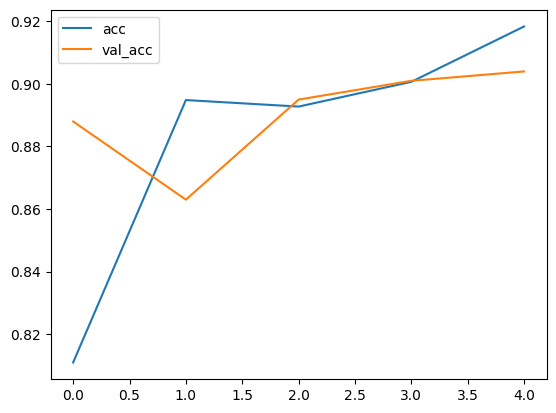

In [ ]:
plt.plot(historyVGG.history['accuracy'], label='acc')
plt.plot(historyVGG.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

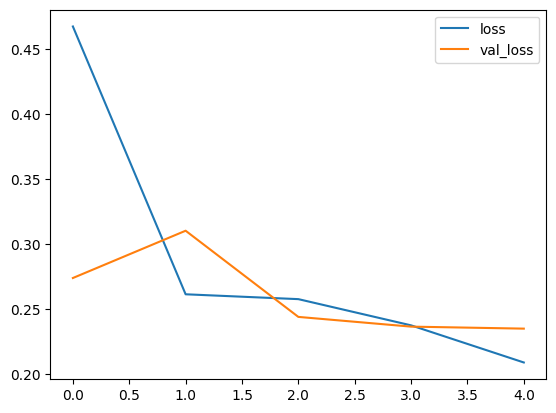

In [ ]:
plt.plot(historyVGG.history['loss'], label='loss')
plt.plot(historyVGG.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

### Prediction

[1. 0.]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


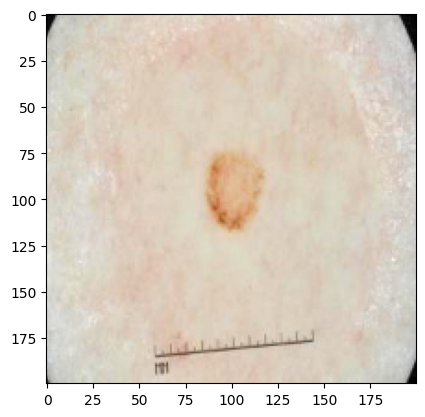

According to custom-CNN, this image most likely belongs to Malignant.
According to VGG16, this image most likely belongs to Malignant.


In [ ]:
class_names = ['Benign', 'Malignant']
number = random.randint(0, X_test.shape[0] - 1)  # Ensure we don't go out of bounds
img_array = np.expand_dims(X_test[number], axis=0)
print(Y_test[number])

predictions = modelCustom.predict(img_array)
score = tf.nn.softmax(predictions[0])

predictions = modelVGG.predict(img_array)
score1 = tf.nn.softmax(predictions[0])

img_to_show = X_test[number].astype(np.float32)
img_to_show = (img_to_show - img_to_show.min()) / (img_to_show.max() - img_to_show.min()) * 255  # Normalize to 0-255
img_to_show = img_to_show.astype(np.uint8)
img_rgb = cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.show()

print("According to custom-CNN, this image most likely belongs to {}.".format(class_names[np.argmax(score)]))
print("According to VGG16, this image most likely belongs to {}.".format(class_names[np.argmax(score1)]))


### Model Evaluation

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step
Custom CNN Confusion Matrix:
[[462  38]
 [ 77 423]]
Custom CNN Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       500
           1       0.92      0.85      0.88       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.88      1000
weighted avg       0.89      0.89      0.88      1000

32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step
VGG16 Confusion Matrix:
[[480  20]
 [ 76 424]]
VGG16 Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       500
           1       0.95      0.85      0.90       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



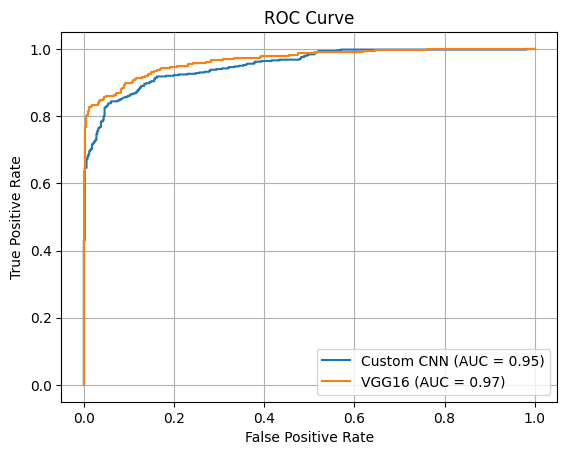

In [ ]:
def evaluate_model(model, X_test, Y_test, model_name):
    y_pred_prob = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(f'{model_name} Confusion Matrix:\n{conf_matrix}')

    class_report = classification_report(y_true, y_pred_classes)
    print(f'{model_name} Classification Report:\n{class_report}')

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    roc_auc = roc_auc_score(y_true, y_pred_prob[:, 1])

    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)

evaluate_model(modelCustom, X_test, Y_test, 'Custom CNN')
evaluate_model(modelVGG, X_test, Y_test, 'VGG16')

plt.show()
